## Import MatPlotLib & Setup

In [111]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

## Import Keras, Pandas & other used libraries

In [112]:
import pandas as pd
import numpy as np

import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

## Import Data

In [113]:
df_game_events = pd.read_csv("../data/game_events.csv")
game_events_features = ['timestamp', 'event_type', 'killer_id', 'killer_name', 'killer_team_id',]

df_game_metadata = pd.read_csv("../data/game_metadata.csv")
game_metadata_features = ['game_id']

df_game_players_stats = pd.read_csv("../data/game_players_stats.csv")
df_game_players_stats.head()

game_players_stats_features_num = ['game_length', 'champion_name', 'tower_kills', 'inhibitor_kills', 'dragon_kills', 'herald_kills', 'baron_kills', 
                               'player_kills', 'player_deaths', 'player_assists','total_minions_killed', 'gold_earned', 'level', 
                               'total_damage_dealt','total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                               'largest_killing_spree', 'largest_multi_kill']

game_players_stats_features_by_user_num = ['player_kills', 'player_deaths', 'player_assists', 'total_minions_killed', 'gold_earned', 'level', 
                                            'total_damage_dealt', 'total_damage_dealt_to_champions', 'total_damage_taken', 'wards_placed', 
                                            'largest_killing_spree', 'largest_multi_kill']
game_players_stats_features_by_user_cat = ['champion_name']

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
match_players = df_game_players_stats[df_game_players_stats['game_id'] == 0]
# match_players.head(10)

# Get league names
unique_leagues = df_game_metadata['league_name'].unique()

# Print only the unique leagues in a clean list format
print(f"Number of unique leagues: {len(unique_leagues)}")
print("List of unique leagues:")
for league in sorted(unique_leagues):
    print(f"- {league}")

Number of unique leagues: 66
List of unique leagues:
- All-Star
- Americas Challengers
- Arabian League
- Baltic Masters
- Belgian League
- CBLOL
- CBLOL Academy
- Challenger Korea
- Coupe de France
- DDH
- Demacia Cup
- Dutch League
- EBL
- EMEA Masters
- Elements League
- Elite Series
- Elite Series Benelux Masters
- Esports World Cup
- European Masters
- European Pro League
- GLL
- Hitpoint Masters
- Iberian Cup
- Ignis Cup
- Karmine Corp vs Ibai Showmatch
- KeSPA Cup
- LCK
- LCK Academy
- LCK Challengers League
- LCL
- LCO
- LCS
- LCS Academy
- LCS Proving Grounds
- LDL
- LEC
- LFL
- LFL Division 2
- LHE
- LIT
- LJL
- LLA
- LMF
- LPL
- LPLOL
- LVP SL
- LVP SL 2nd Division
- Mid-Season Cup
- Mid-Season Invitational
- NEST
- NLC
- North American Challengers League
- OPL
- PCS
- PG Nationals
- Prime League 1st Division
- Prime League Super Cup
- Prime Pokal
- Red Bull League of Its Own
- Season Kickoff
- Superdome
- TCL
- TCL Division 2
- Ultraliga
- VCS
- Worlds


## Import models & tools

In [114]:
import joblib

top_model = keras.models.load_model('role_models/top_model.keras')
jungle_model = keras.models.load_model('role_models/jungle_model.keras')
mid_model = keras.models.load_model('role_models/mid_model.keras')
sup_model = keras.models.load_model('role_models/sup_model.keras')
bot_model = keras.models.load_model('role_models/bot_model.keras')

models_by_role = {
    'Top': top_model,
    'Jungle': jungle_model,
    'Mid': mid_model,
    'Support': sup_model,
    'Bot': bot_model
}

win_loose_preprocessor = joblib.load('tools/win_loose_preprocessor.pkl')

## Import functions

In [115]:
def get_useful_players_data(dataframe : pd.DataFrame) -> pd.DataFrame:
    new_df = pd.DataFrame()
    
    new_df['KLA'] = (dataframe['player_kills'] + dataframe['player_assists']) / (dataframe['player_deaths'] + 1)
    new_df['gold_pm'] = dataframe['gold_earned'] / dataframe['game_length']
    new_df['lvl_pm'] = dataframe['level'] / dataframe['game_length']
    new_df['creep_score_pm'] = dataframe['total_minions_killed'] / dataframe['game_length']
    new_df['wards_pm'] = dataframe['wards_placed'] / dataframe['game_length']
    
    new_df['damage_pm'] = dataframe['total_damage_dealt'] / dataframe['game_length']
    new_df['damage_to_champions_pm'] = dataframe['total_damage_dealt_to_champions'] / dataframe['game_length']
    new_df['damage_taken_pm'] = dataframe['total_damage_taken'] / dataframe['game_length']
    
    new_df['greatest_killing_spree'] = dataframe['largest_killing_spree']
    new_df['greatest_multi_kill'] = dataframe['largest_multi_kill']
    
    return new_df

def get_solo_player_data(player_id : int, game_id : int) -> pd.DataFrame:
    """
    Get player data for a specific player and game.
    """
    # Filter by game_id first
    df_player = df_game_players_stats[df_game_players_stats['game_id'] == game_id]
    
    # Filter by player_id
    df_player = df_player[df_player['player_id'] == player_id]
    
    df_player_selected = get_useful_players_data(df_player)
    
    return df_player_selected

useful_player_columns_num = ['KLA', 'gold_pm', 'lvl_pm', 'creep_score_pm', 'wards_pm',
                            'damage_pm', 'damage_to_champions_pm', 'damage_taken_pm',
                            'greatest_killing_spree', 'greatest_multi_kill']

player_roles = ['Top', 'Jungle', 'Mid', 'Support', 'Bot']

def group_split(X: pd.DataFrame, y: pd.Series, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

def get_role_data(role: str, test_game_id: int | None = None) -> tuple:
    X = df_game_players_stats.loc[df_game_players_stats['role'] == role].copy()
    
    if test_game_id is not None:
        X = X.loc[X['game_id'] != test_game_id].copy()
    
    y = X['win'].copy()
    group = X['game_id'].copy()
    
    X = get_useful_players_data(X)
    
    X_train, X_valid, y_train, y_test = group_split(X, y, group)
    
    X_train = win_loose_preprocessor.fit_transform(X_train)
    X_valid = win_loose_preprocessor.transform(X_valid)
    
    return X_train, X_valid, y_train, y_test

## Compute Win probability for each player in each game

In [116]:
def compute_player_win_probabilities(df_players, models_by_role, batch_size=64):
    """
    Compute win probability for each player in each game using role-specific models.
    Optimized for speed with batched predictions.
    
    Args:
        df_players: DataFrame with player stats
        models_by_role: Dictionary of trained models for each role
        batch_size: Number of samples to process at once
    
    Returns:
        DataFrame with player IDs, game IDs, roles, and win probabilities
    """
    # Suppress TensorFlow logging and warnings
    import os
    import logging
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    
    # Dictionary to store predictions by role
    results = []
    role_groups = df_players.groupby('role')
    
    # Process one role at a time
    for role, role_df in role_groups:
        print(f"Processing role: {role}")
        
        if role not in models_by_role:
            continue
            
        model = models_by_role[role]
        
        # Group players by game to enable batch processing
        game_player_groups = role_df.groupby(['player_id', 'game_id'])
        
        # Collect all data for this role
        all_player_ids = []
        all_game_ids = []
        all_preprocessed_data = []
        all_wins = []
        
        for (player_id, game_id), player_data in game_player_groups:
            X_player = get_useful_players_data(player_data)
            X_player_preprocessed = win_loose_preprocessor.transform(X_player)
            
            all_player_ids.append(player_id)
            all_game_ids.append(game_id)
            all_preprocessed_data.append(X_player_preprocessed)
            all_wins.append(player_data['win'].iloc[0])
        
        # If no players for this role, continue
        if not all_preprocessed_data:
            continue
            
        # Convert to appropriate format for batch prediction
        X_batch = np.vstack(all_preprocessed_data)
        
        # Make predictions in batch (much faster!)
        print(f"Processing {len(X_batch)} predictions for role: {role}")
        win_probabilities = model.predict(X_batch, batch_size=batch_size, verbose=0).flatten()
        
        # Store results
        for i in range(len(all_player_ids)):
            results.append({
                'player_id': all_player_ids[i],
                'game_id': all_game_ids[i],
                'role': role,
                'win_probability': win_probabilities[i],
                'actual_outcome': all_wins[i]
            })
    
    return pd.DataFrame(results)

## Compute performance metrics & Normalize them

In [117]:
def calculate_player_performance_metrics(win_probabilities_df):
    """
    Calculate performance metrics for each player across all games.
    
    Args:
        win_probabilities_df: DataFrame with win probabilities
    
    Returns:
        DataFrame with player performance metrics
    """
    # Group by player_id
    player_metrics = []
    
    for player_id, player_games in win_probabilities_df.groupby('player_id'):
        # Calculate metrics
        avg_win_probability = player_games['win_probability'].mean()
        num_games = len(player_games)
        actual_win_rate = player_games['actual_outcome'].mean()
        
        # Calculate "impact score" - how much better the player performs than predicted
        # This could be a measure of clutch performance or consistency
        impact_score = actual_win_rate - avg_win_probability
        
        # Calculate variance in performance
        win_prob_variance = player_games['win_probability'].var()
        
        # Store metrics
        player_metrics.append({
            'player_id': player_id,
            'role': player_games['role'].iloc[0],  # Assuming player always plays same role
            'num_games': num_games,
            'avg_win_probability': avg_win_probability,
            'actual_win_rate': actual_win_rate,
            'impact_score': impact_score,
            'performance_consistency': 1 - win_prob_variance  # Higher is more consistent
        })
    
    return pd.DataFrame(player_metrics)

def normalize_performance_by_role(player_metrics_df):
    """
    Transform performance metrics to percentiles within each role.
    
    Args:
        player_metrics_df: DataFrame with player performance metrics
    
    Returns:
        DataFrame with normalized performance metrics
    """
    normalized_df = player_metrics_df.copy()
    
    # List of metrics to normalize
    metrics_to_normalize = [
        'avg_win_probability', 
        'impact_score', 
        'performance_consistency'
    ]
    
    # Normalize each metric within role
    for role in player_metrics_df['role'].unique():
        role_mask = normalized_df['role'] == role
        role_df = normalized_df[role_mask]
        
        for metric in metrics_to_normalize:
            # Calculate percentile rank for this metric within this role
            percentile_values = role_df[metric].rank(pct=True)
            
            # Update normalized DataFrame
            normalized_df.loc[role_mask, f'{metric}_percentile'] = percentile_values
    
    return normalized_df

## Categorize Leagues by region to compute meta rankings

In [118]:
def categorize_leagues_by_region(df_metadata):
    """
    Categorize each league in the dataset into a geographical region.
    
    Args:
        df_metadata: DataFrame containing league_name column
        
    Returns:
        Dictionary mapping each league to its region and DataFrame with region information
    """
    # Define region mappings (based on common esports regions)
    region_mapping = {
        # Korea
        'LCK': 'Korea',
        'LCK CL': 'Korea',
        'LCK Academy': 'Korea',
        'LCK Challengers League': 'Korea',
        'Challenger Korea': 'Korea',
        'KeSPA Cup': 'Korea',
        
        # China
        'LPL': 'China',
        'LPLOL': 'China',
        'LDL': 'China',
        'Demacia Cup': 'China',
        'NEST': 'China',
        
        # Europe
        'LEC': 'Europe',
        'European Masters': 'Europe',
        'European Pro League': 'Europe',
        'EMEA Masters': 'Europe',
        'LFL': 'Europe',  # French league
        'LFL Division 2': 'Europe',
        'Coupe de France': 'Europe',
        'LVP SL': 'Europe',  # Spanish league
        'LVP SL 2nd Division': 'Europe',
        'Iberian Cup': 'Europe',
        'Prime League 1st Division': 'Europe',  # DACH region
        'Prime League Super Cup': 'Europe',
        'Prime Pokal': 'Europe',
        'Ultraliga': 'Europe',  # Polish league
        'NLC': 'Europe',  # Northern League Championship
        'PG Nationals': 'Europe',  # Italian league
        'Elite Series': 'Europe',  # Benelux
        'Elite Series Benelux Masters': 'Europe',
        'Hitpoint Masters': 'Europe',  # Czech/Slovak
        'Esports Balkan League': 'Europe',
        'EBL': 'Europe',  # Esports Balkan League
        'TCL': 'Europe',  # Turkey
        'TCL Division 2': 'Europe',
        'Baltic Masters': 'Europe',
        'Belgian League': 'Europe',
        'Dutch League': 'Europe',
        'Elements League': 'Europe',
        'GLL': 'Europe',  # Greek League
        'LHE': 'Europe',  # Hellenic League
        'LIT': 'Europe',  # Italian League
        'LMF': 'Europe',  # French Minor League
        'DDH': 'Europe',  # German Division
        'Ignis Cup': 'Europe',
        
        # Japan
        'LJL': 'Japan',
        
        # North America
        'LCS': 'North America',
        'LCS Academy': 'North America',
        'LCS Proving Grounds': 'North America',
        'North American Challengers League': 'North America',  # NACL
        'Americas Challengers': 'North America',
        
        # South America
        'LLA': 'Latin America',  # Latin America
        
        # Brazil
        'CBLOL': 'Brazil',  # Brazil
        'CBLOL Academy': 'Brazil',
        
        # Asia Pacific
        'PCS': 'Asia Pacific',  # Pacific Championship Series
        'OPL': 'Asia Pacific',  # Oceanic Pro League
        'LCO': 'Asia Pacific',  # League of Legends Circuit Oceania
        
        # Vietnam
        'VCS': 'Vietnam',  # Vietnam Championship Series
        
        # Other regions
        'LCL': 'CIS',  # Commonwealth of Independent States
        'Arabian League': 'Middle East',
        
        # International events
        'Worlds': 'International',
        'Mid-Season Invitational': 'International',
        'All-Star': 'International',
        'Season Kickoff': 'International',
        'Mid-Season Cup': 'International',
        'Esports World Cup': 'International',
        'Superdome': 'International',
        'Karmine Corp vs Ibai Showmatch': 'International',
        'Red Bull League of Its Own': 'International'
    }
    
    # Get unique leagues
    leagues = df_metadata['league_name'].unique()
    
    # Create a dictionary to store leagues by region
    leagues_by_region = {
        'Korea': [],
        'China': [],
        'Europe': [],
        'North America': [],
        'Latin America': [],
        'Brazil': [],
        'Asia Pacific': [],
        'Vietnam': [],
        'Japan': [],
        'Middle East': [],
        'CIS': [],
        'International': [],
        'Others': []
    }
    
    # Categorize each league
    for league in leagues:
        if league in region_mapping:
            region = region_mapping[league]
            # Add to the specific region
            if region in leagues_by_region:
                leagues_by_region[region].append(league)
            else:
                # For regions we didn't explicitly list as categories
                leagues_by_region['Others'].append(league)
        else:
            # If we don't have a mapping, put it in Others
            leagues_by_region['Others'].append(league)
    
    # Create DataFrame with league to region mapping
    league_region_df = pd.DataFrame({
        'league_name': [league for region in leagues_by_region.values() 
                      for league in region],
        'region': [region for region, leagues in leagues_by_region.items() 
                 for _ in range(len(leagues))]
    })
    
    return leagues_by_region, league_region_df

leagues_by_region, league_region_df = categorize_leagues_by_region(df_game_metadata)


## Add regional strength factors to represent real world rankings

In [119]:
def compute_region_strength_factors(df_game_players_stats, df_game_metadata, league_region_df):
    """
    Dynamically compute regional strength factors based on:
    1. International competition results
    2. Statistical performance metrics
    3. Player mobility between regions
    """
    # Merge player stats with game metadata and region info
    df_player_games = df_game_players_stats.merge(
        df_game_metadata[['game_id', 'league_name', 'date']], 
        on='game_id'
    ).merge(
        league_region_df, 
        on='league_name'
    )
    
    # Step 1: Initialize baseline weights
    baseline_weights = {
        'Korea': 1.10,      # Starting baseline
        'China': 1.08,
        'Europe': 1.05,
        'North America': 1.00,  # Reference point
        'Vietnam': 0.95,
        'Asia Pacific': 0.95,
        'Brazil': 0.90,
        'Latin America': 0.90,
        'Japan': 0.90,
        'CIS': 0.90,
        'Middle East': 0.85,
        'International': 1.10,
        'Others': 0.90
    }
    
    # Step 2: Calculate region performance metrics
    region_stats = {}
    
    # Only use international events to calibrate regional strength
    international_games = df_player_games[df_player_games['region'] == 'International']
    
    if len(international_games) > 0:
        # Track wins by region in international competition
        international_results = []
        
        for game_id, game_data in international_games.groupby('game_id'):
            # Get the two teams in this game
            teams = game_data['team_id'].unique()
            if len(teams) == 2:
                # Get winner
                winning_team = game_data[game_data['win'] == True]['team_id'].iloc[0]
                losing_team = teams[0] if teams[0] != winning_team else teams[1]
                
                # Get regions for each team (most common region per player)
                winner_primary_region = game_data[game_data['team_id'] == winning_team]['region'].mode().iloc[0]
                loser_primary_region = game_data[game_data['team_id'] == losing_team]['region'].mode().iloc[0]
                
                # Record result if teams are from different regions
                if winner_primary_region != loser_primary_region and \
                   winner_primary_region != 'International' and \
                   loser_primary_region != 'International':
                    international_results.append({
                        'winning_region': winner_primary_region,
                        'losing_region': loser_primary_region,
                        'date': game_data['date'].iloc[0]
                    })
        
        # Calculate win rates by region
        if international_results:
            region_wins = {}
            region_losses = {}
            region_matches = {}
            
            for result in international_results:
                winner = result['winning_region']
                loser = result['losing_region']
                
                # Update wins
                region_wins[winner] = region_wins.get(winner, 0) + 1
                # Update losses
                region_losses[loser] = region_losses.get(loser, 0) + 1
                # Update match counts
                region_matches[winner] = region_matches.get(winner, 0) + 1
                region_matches[loser] = region_matches.get(loser, 0) + 1
            
            # Calculate win rates with Bayesian smoothing for regions with few games
            smoothing_factor = 5  # Prevents extreme values for regions with few games
            
            for region in set(region_matches.keys()):
                wins = region_wins.get(region, 0)
                matches = region_matches.get(region, 0)
                
                # Bayesian win rate (with prior of 0.5)
                win_rate = (wins + (smoothing_factor * 0.5)) / (matches + smoothing_factor)
                
                # Calculate strength modifier (centered around 1.0)
                strength_modifier = 0.5 + win_rate
                
                # Update region stats
                region_stats[region] = {
                    'wins': wins,
                    'matches': matches,
                    'win_rate': win_rate,
                    'strength_modifier': strength_modifier
                }
    
    # Step 3: Calculate final strength factors
    final_strength = {}
    for region, baseline in baseline_weights.items():
        if region in region_stats:
            # Blend baseline with computed strength (70% computed + 30% baseline)
            final_strength[region] = 0.7 * region_stats[region]['strength_modifier'] + 0.3 * baseline
        else:
            # If no international data, use baseline
            final_strength[region] = baseline
    
    # Normalize to keep Korea at the top reference point
    max_strength = max(final_strength.values())
    reference_strength = 1.20  # Maximum desired strength value
    
    for region in final_strength:
        final_strength[region] = (final_strength[region] / max_strength) * reference_strength
    
    return final_strength

## Compute region meta ranking

In [120]:
def compute_region_meta_ranking(normalized_metrics_df, df_game_metadata, league_region_df):
    """
    Compute a meta ranking for players based on their region with dynamic strength factors.
    """
    # First, add the league information to each player's games
    df_player_leagues = df_game_players_stats[['player_id', 'game_id']].merge(
        df_game_metadata[['game_id', 'league_name']], 
        on='game_id'
    )
    
    # Add region information
    df_player_regions = df_player_leagues.merge(league_region_df, on='league_name')
    
    # Get the primary region for each player (most common region they played in)
    player_regions = df_player_regions.groupby('player_id')['region'].agg(
        lambda x: x.value_counts().index[0]
    ).reset_index()
    
    # Add region to normalized metrics
    df_with_regions = normalized_metrics_df.merge(player_regions, on='player_id', how='left')
    
    # Get dynamic regional strength factors
    region_strength = compute_region_strength_factors(
        df_game_players_stats, df_game_metadata, league_region_df
    )
    
    # Add region strength to player data
    df_with_regions['region_strength'] = df_with_regions['region'].map(region_strength).fillna(0.9)
    
    # Calculate region-specific metrics with strength adjustment
    region_metrics = {}
    for region in df_with_regions['region'].unique():
        if pd.isna(region):
            continue
            
        region_df = df_with_regions[df_with_regions['region'] == region]
        region_strength_value = region_strength.get(region, 1.0)
        
        # Calculate metrics for each role within region
        for role in region_df['role'].unique():
            role_region_df = region_df[region_df['role'] == role]
            
            # Need minimum number of players for meaningful percentiles
            if len(role_region_df) < 5:
                continue
                
            # Calculate regional percentile ranks with strength adjustment
            for metric in ['avg_win_probability', 'impact_score', 'performance_consistency']:
                # Adjust values by region strength before ranking
                adjusted_values = role_region_df[metric] * region_strength_value
                percentile_values = adjusted_values.rank(pct=True)
                
                region_key = f"{region}_{role}"
                if region_key not in region_metrics:
                    region_metrics[region_key] = {}
                    
                region_metrics[region_key][metric] = dict(zip(role_region_df['player_id'], percentile_values))
    
    # Add region meta percentiles to player data
    df_with_regions['region_win_prob_percentile'] = None
    df_with_regions['region_impact_percentile'] = None
    df_with_regions['region_consistency_percentile'] = None
    
    for idx, row in df_with_regions.iterrows():
        region_key = f"{row['region']}_{row['role']}"
        if region_key in region_metrics:
            player_id = row['player_id']
            
            metrics = region_metrics[region_key]
            if player_id in metrics.get('avg_win_probability', {}):
                df_with_regions.at[idx, 'region_win_prob_percentile'] = metrics['avg_win_probability'][player_id]
                
            if player_id in metrics.get('impact_score', {}):
                df_with_regions.at[idx, 'region_impact_percentile'] = metrics['impact_score'][player_id]
                
            if player_id in metrics.get('performance_consistency', {}):
                df_with_regions.at[idx, 'region_consistency_percentile'] = metrics['performance_consistency'][player_id]
    
    # Calculate overall region meta score (for players with enough data)
    valid_mask = df_with_regions['region_win_prob_percentile'].notnull()
    df_with_regions['region_meta_score'] = None
    
    # Use numpy to avoid the type warning
    if valid_mask.any():
        win_prob = df_with_regions.loc[valid_mask, 'region_win_prob_percentile'].to_numpy() * 0.4
        impact = df_with_regions.loc[valid_mask, 'region_impact_percentile'].to_numpy() * 0.3
        consistency = df_with_regions.loc[valid_mask, 'region_consistency_percentile'].to_numpy() * 0.3
        
        df_with_regions.loc[valid_mask, 'region_meta_score'] = win_prob + impact + consistency
    
    return df_with_regions

## Compute Skill rank

In [121]:
def compute_enhanced_skill_rank(normalized_metrics_df, df_game_metadata, league_region_df, weights=None, min_games=5):
    """
    Compute enhanced skill rank incorporating region meta rankings with improved 
    handling of regional strength differences.
    
    Args:
        normalized_metrics_df: DataFrame with normalized metrics
        df_game_metadata: DataFrame with game metadata
        league_region_df: DataFrame mapping leagues to regions
        weights: Optional dictionary of weights for metrics
        min_games: Minimum number of games required for ranking
        
    Returns:
        DataFrame with enhanced player skills and ranks
    """
    # Filter by minimum game count
    filtered_df = normalized_metrics_df[normalized_metrics_df['num_games'] >= min_games].copy()
    
    # Get region meta rankings with strength factors
    region_df = compute_region_meta_ranking(filtered_df, df_game_metadata, league_region_df)
    
    if weights is None:
        weights = {
            'avg_win_probability_percentile': 0.25,
            'impact_score_percentile': 0.20, 
            'performance_consistency_percentile': 0.15,
            'region_meta_score': 0.40  # Increased weight for region meta score to reflect paper's emphasis
        }
    
    # Calculate reliability factor - more games = more reliable data
    # Using exponential growth function similar to paper's approach
    region_df['reliability'] = 1 - np.exp(-0.1 * region_df['num_games'])
    
    # Initialize skill score column
    region_df['skill_score'] = 0.0  
    
    # Add global metrics with exponential weighting to emphasize exceptional performance
    for metric in ['avg_win_probability_percentile', 'impact_score_percentile', 'performance_consistency_percentile']:
        if metric in weights:
            # Apply element-wise multiplication with non-linear scaling
            region_df['skill_score'] += (
                region_df[metric] * weights[metric] * region_df['reliability']
            )
    
    # Add region meta score if available with regional strength consideration
    if 'region_meta_score' in weights:
        has_region = region_df['region_meta_score'].notnull()
        
        if has_region.any():
            # Add the regional component with explicit conversion to float
            region_df.loc[has_region, 'skill_score'] += (
                region_df.loc[has_region, 'region_meta_score'].astype(float) * 
                weights['region_meta_score'] * 
                region_df.loc[has_region, 'reliability']
            )
            
            # For players without region data, redistribute region weight
            if (~has_region).any():
                region_weight = weights['region_meta_score']
                remaining_weight = sum(weights.values()) - region_weight
                
                for metric in ['avg_win_probability_percentile', 'impact_score_percentile', 'performance_consistency_percentile']:
                    if metric in weights:
                        extra_weight = weights[metric] / remaining_weight * region_weight
                        region_df.loc[~has_region, 'skill_score'] += (
                            region_df.loc[~has_region, metric] * 
                            extra_weight * 
                            region_df.loc[~has_region, 'reliability']
                        )
    
    # Calculate overall rank
    region_df['skill_rank'] = region_df['skill_score'].rank(ascending=False)
    
    # Add player names
    player_names = df_game_players_stats[['player_id', 'player_name']].drop_duplicates()
    region_df = region_df.merge(player_names, on='player_id')
    
    return region_df.sort_values('skill_rank')

## Generate win probabilities

In [122]:
# Generate win probabilities with a larger batch size for speed
# print("Starting win probability calculations...")
# df_win_probs = compute_player_win_probabilities(df_game_players_stats, models_by_role, batch_size=15000)
# print(f"Finished processing {len(df_win_probs)} player predictions")

## Save probabilities

In [123]:

# def save_proba():
#     os.makedirs('computed_dataframe/', exist_ok=True)
#     df_win_probs.to_csv('computed_dataframe/win_probabilities.csv', index=False)
    
# save_proba()

## Import CSV already computed (18min with RTX 3060)

In [124]:
df_win_probs = pd.read_csv('computed_dataframe/win_probabilities.csv')

## Generate performance

In [125]:
df_performance_metrics = calculate_player_performance_metrics(df_win_probs)

df_normalized_metrics = normalize_performance_by_role(df_performance_metrics)

## Generate Skill rankings

In [128]:
# Display enhanced rankings with region and meta score
enhanced_rankings = compute_enhanced_skill_rank(df_normalized_metrics, df_game_metadata, league_region_df)

# Create a formatted display function
def display_enhanced_rankings(rankings, top_n=40):
    """
    Display enhanced rankings with clear region and meta score information.
    """
    display_cols = [
        'skill_rank', 'player_name', 'role', 'region', 
        'region_strength', 'region_meta_score', 'skill_score', 
        'num_games', 'avg_win_probability', 'actual_win_rate'
    ]
    
    # Format the output
    display_df = rankings[display_cols].head(top_n).copy()
    
    # Add rank column prefix
    display_df['skill_rank'] = display_df['skill_rank'].apply(lambda x: f"#{int(x)}")
    
    # Format percentages
    for col in ['skill_score', 'avg_win_probability', 'actual_win_rate', 'region_meta_score']:
        if col in display_df.columns:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "N/A")
            
    # Format region strength
    if 'region_strength' in display_df.columns:
        display_df['region_strength'] = display_df['region_strength'].apply(
            lambda x: f"{x:.2f}x" if pd.notnull(x) else "N/A"
        )
    
    return display_df.set_index('skill_rank')

# Display top players with enhanced format
display_enhanced_rankings(enhanced_rankings)

,player_name,role,region,region_strength,region_meta_score,skill_score,num_games,avg_win_probability,actual_win_rate
skill_rank,,,,,,,,,
#1,jiang,Bot,China,1.18x,0.867,0.870,128,0.665,0.727
#2,Snow,Bot,China,1.18x,0.883,0.870,61,0.827,0.852
#3,LYONZ,Bot,Latin America,0.98x,0.888,0.868,188,0.569,0.713
#4,Limitationss,Bot,Europe,1.15x,0.875,0.856,47,0.732,0.766
#5,Violet,Bot,Asia Pacific,1.04x,0.900,0.839,29,0.651,0.724
#6,Peyz,Bot,Korea,1.20x,0.855,0.838,329,0.674,0.708
#7,Kz,Bot,Europe,1.15x,0.853,0.836,40,0.606,0.675
#8,Clever9,Top,China,1.18x,0.825,0.834,43,0.544,0.721
#9,EMENES,Mid,North America,1.09x,0.842,0.833,155,0.591,0.690


## Visualize skill rankings

C:\Users\doria\AppData\Local\Temp\ipykernel_32112\2946341948.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  top_players['other_contribution'] = top_players['skill_score'] - top_players['meta_contribution'].fillna(0)


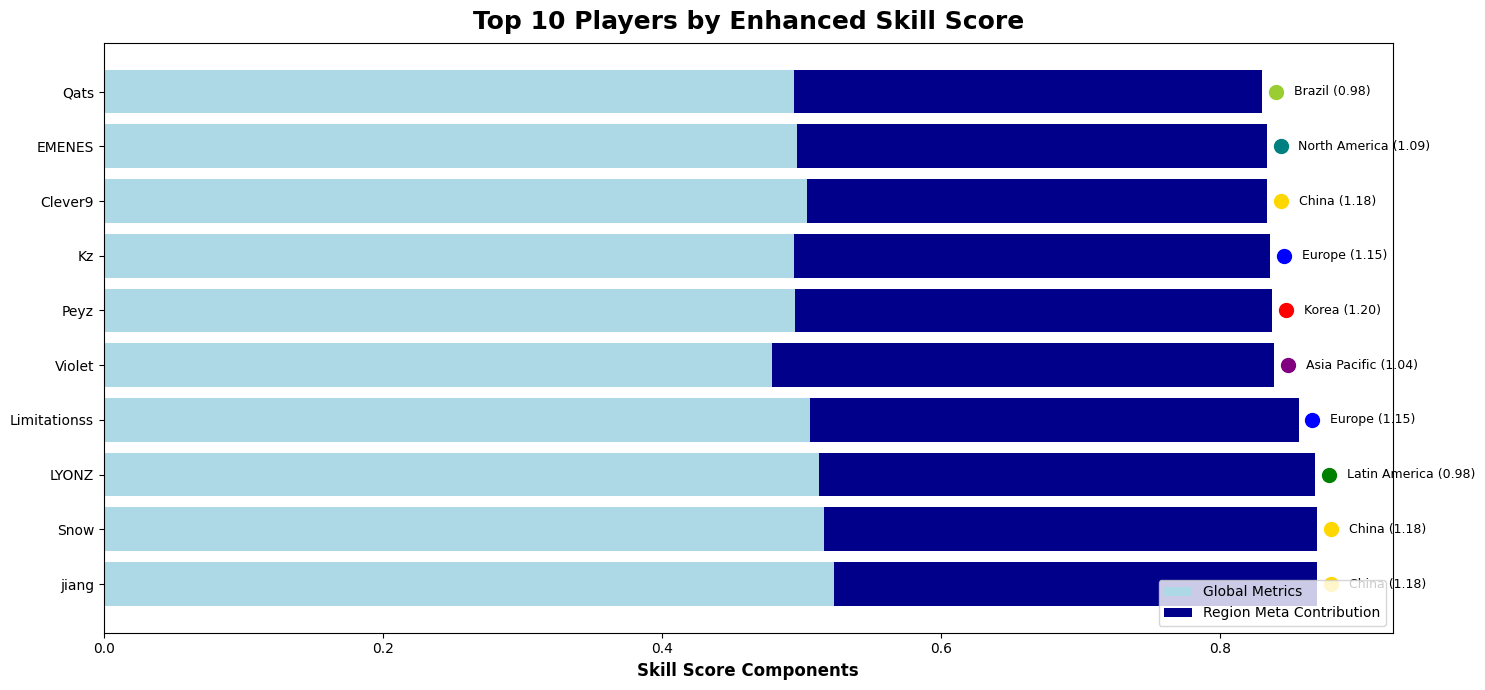

In [129]:
def visualize_enhanced_rankings_with_meta(rankings):
    """
    Create visualizations of enhanced player rankings showing meta score contribution.
    """
    # Top players overall
    top_players = rankings.sort_values('skill_score', ascending=False).head(10)
    
    plt.figure(figsize=(15, 7))
    
    # Calculate the meta score contribution vs other components
    top_players['meta_contribution'] = top_players['region_meta_score'] * 0.4  # Updated weight
    top_players['other_contribution'] = top_players['skill_score'] - top_players['meta_contribution'].fillna(0)
    
    # Create stacked bars
    y_pos = range(len(top_players))
    plt.barh(y_pos, top_players['other_contribution'], color='lightblue', label='Global Metrics')
    plt.barh(y_pos, top_players['meta_contribution'], left=top_players['other_contribution'], 
             color='darkblue', label='Region Meta Contribution')
    
    # Add region markers with better visibility
    region_colors = {
        'Korea': 'red',
        'China': 'gold',
        'Europe': 'blue',
        'North America': 'teal',
        'Latin America': 'green',
        'Brazil': 'yellowgreen',
        'Asia Pacific': 'purple',
        'Vietnam': 'pink',
        'Japan': 'orange',
        'International': 'gray',
        'Middle East': 'brown',
        'CIS': 'cyan'
    }
    
    for i, (_, player) in enumerate(top_players.iterrows()):
        region = player['region']
        if pd.notna(region):
            plt.plot(player['skill_score'] + 0.01, i, 'o', 
                     color=region_colors.get(region, 'black'), 
                     markersize=10)
            plt.text(player['skill_score'] + 0.02, i, 
                    f" {region} ({player['region_strength']:.2f})", 
                    va='center', fontsize=9)
    
    plt.yticks(y_pos, top_players['player_name'])
    plt.xlabel('Skill Score Components')
    plt.title('Top 10 Players by Enhanced Skill Score')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Visualize with enhanced meta score contributions
visualize_enhanced_rankings_with_meta(enhanced_rankings)